1.0


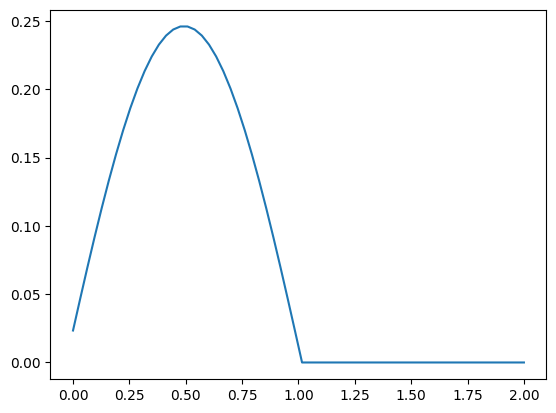

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
from math import pi
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

# Preparing the sine-shaped histogram that will be used in the initialisation
L = 1
x = np.linspace(0, L, num=34)
x = np.delete(x, [0, 33])
zero = np.zeros(32)
x = np.append(x, zero)
xaxis = np.linspace(0, 2 * L, num=64)

Normalisation_wavefunction = (np.sqrt(2 / L) * np.sin(pi * x / L))
Normalisation_Constant = np.sqrt(np.sum(Normalisation_wavefunction**2))
waveFunction = (Normalisation_wavefunction) / (Normalisation_Constant)

print(np.sum(waveFunction**2))
plt.plot(xaxis, waveFunction)
plt.show()

In [4]:


# Parameters
phi = 0.1
V = 1000
qb = 6  # Number of active qubits (not including Ancilla)
cbits = 6

# Quantum and classical registers
q = QuantumRegister(qb + 1)
c = ClassicalRegister(cbits)
qc = QuantumCircuit(q)
qc2 = QuantumCircuit(q, c)

# Initialisation
initialisation = QuantumCircuit(q, c)
initialisation.initialize(waveFunction, [q[1], q[2], q[3], q[4], q[5], q[6]])
initialisation.draw()

# Functions for QFT, Time Evolution, and Inverse QFT
def QFT(qubits):
    qc.swap(1, 6)
    qc.swap(2, 5)
    qc.swap(3, 4)
    for i in range(qubits):
        qc.h(i + 1)
        for j in range(qubits - 1 - i):
            qc.cp(pi / (2 ** (j + 1)), i + 2 + j, i + 1)

def Time_Evolution(qubits):
    for i in range(qubits):
        qc.p(phi / (2 ** (i + qubits - 3)), qubits - i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            qc.cx(qubits - j, 0)
            qc.cx(qubits - i, 0)
            qc.p(phi * (2 ** (2 - i - j)), 0)
            qc.cx(qubits - i, 0)
            qc.cx(qubits - j, 0)

def QFT_Inv(qubits):
    for i in reversed(range(qubits)):
        for j in range(qubits - 1 - i):
            qc.cp(-pi / (2 ** (j + 1)), i + 2 + j, i + 1)
        qc.h(i + 1)
    qc.swap(1, 6)
    qc.swap(2, 5)
    qc.swap(3, 4)

# Main loop
for l in range(20):
    qc2.initialize(waveFunction, [q[1], q[2], q[3], q[4], q[5], q[6]])

    # Potential
    qc.p(V * phi, qb)

    # Quantum Fourier Transform
    QFT(qb)
    qc.x(qb)

    # Time Evolution
    Time_Evolution(qb)

    # Inverse Quantum Fourier Transform
    qc.x(qb)
    QFT_Inv(qb)

    for i in range(l):
        qc2.append(qc, [0, 1, 2, 3, 4, 5, 6])

    # Measurement
    for k in range(qb):
        qc2.measure(k + 1, k)

    # Execute the circuit
    backend = AerSimulator()
    shots = 65536
    transpiled_circuit = transpile(qc2, backend)
    job = backend.run(transpiled_circuit, shots=shots)
    results = job.result()
    answer = results.get_counts()

    # Fill missing states with 0 probability
    for a in range(2**qb):
        s = '{0:06b}'.format(a)
        if s not in answer.keys():
            answer[s] = 0

    # Normalize the counts to get probabilities (percentages)
    total_shots = sum(answer.values())
    probabilities = {state: total_shots / shots  for state, total_shots in answer.items()}

    # Plot and save the histogram
    plot_histogram(probabilities, title="Particle in a Step Potential", figsize=[20, 10]).savefig(f'{l}.png')

    # Reset the circuit data
    qc2.data = []